# Desarrollo
## Avances
- Cargadas las señales en formato MNE y preprocesadas, falta revisar si funciona correctamente

## Conclusiones
- Hay que ver como cargar el archivo de montage para MNE.

In [29]:
#LIBRERÍAS

#Librerías de Sistema
import os
import sys

#Librerías de Manejo de Datos
import pandas as pd
import numpy as np

#Librerías de Interfaz
from tkinter import filedialog
from tkinter import *
from tkinter import messagebox

#Librerías para EEG
import mne

#Librerías para Plotings
import matplotlib.pyplot as plt

### Variables Globales 

In [30]:
#definimos las variables de antemano para que las use todo el algoritmo, como globales
usecols = 0   #columnas a utilizar del archivo de señal
skiprows = 0  #Filas a saltear del archivo de señal
sep = ","     #Símbolo que separa columnas en el archivo de señal

col_names = [] #Lista para nombre de las columnas
col_types = [] #Lista para el tipo de datos en cada columna

chan_quant = 0 #Cantidad de columnas que son del tipo "Channel"

chan_pos = []  #Posiciones en las que se colocaron los electrodos de cada canal
chan_selecc = [] #Lista de canales que se van a utilizar del total presentes en el archivo de señal

fq_lo = 0      #frequencia baja del filtro pasabanda
fq_hi = 0      #frecuencia alta del filtro pasabanda
fq_no = 0      #frecuencia del filtro notch
fq_sub = 0     #frecuencia de submuestreo

### Funciones

In [31]:
#we create the function get indexes
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

#This would work like : X = ["Mario", "Luigi", "Yoshi", "Mario"]
#print(get_indexes("Mario", X)) -> Out: [0,3]
#print(get_indexes("Luigi", X)) -> Out: [1]

In [32]:
def yn_quest(quest):
    while True:
        answ = input(quest + ' [Y/N]: ')
        if answ == 'Y' or answ == 'y' or answ == 'N' or answ == 'n':
            break
        else:
            print('The entered answer is incorrect, please try again.')
    return answ

In [33]:
def load_signal():   
    nom_s = input("Wich will be the signal name? ")

    while True:
        root = Tk() #Crea la ventana root
        xs = filedialog.askopenfilename(title = "Select Signal File :",          #Dice que va a sacar la variable Xs como el filename de un archivo
                                        filetypes = (("Documento de texto","*.txt"),
                                                     ("Excel (post 2003)", ".xlsx"),
                                                     ("Excel (prev 2003)", ".xls"),
                                                     ("Todos los archivos","*.*")
                                                    ) #Con titulo de ventana y opciones de abrir archivos de ese tipo
                                       ) 
        root.mainloop() #esto es para que la ventana quede abierta hasta que se de una respuesta, en este caso la selección de un archivo
        
        print (xs)

        if ".txt" in xs:
            opt = yn_quest('Is it a file exported by the OpenBCI Software?')
            if opt == 'Y' or opt == 'y':
                XS = openbci_topd(xs)
            else:
                XS = csv_topd(xs)
            print("Signal Loaded. TXT format.")
            break
        
        elif ".xlsx" in xs or ".xls" in xs:
            XS = excel_topd(xs, interval = False)
            print("Signal Loaded. Excel format.") #Esto sería reemplazado por la función "leer txt" que tomaría la dirección y parámetros como Cantidad de columnas, Nombres de columnas, etc (o se puede probar con la direccion sola y si no funciona pedir parametros)
            break

        elif xs == "":
            print("Cancelled Operation")
            break

        else:
            print("Wrong File Format. Try Again.")
            break

    return XS, nom_s

In [34]:
def csv_topd(truepath):
    global usecols
    global skiprows
    global sep
    global col_names
    global col_types
    
    while True:
        col_rows_sep()
        
        save_opt = input('Do you wish to save this configuration?: ') #Completar, cómo y dónde y la carga de la configuracion
        
        try:
            X = pd.read_csv(truepath,  sep=sep, skiprows=skiprows, names=col_names, usecols=range(usecols), lineterminator = '\n')
        except:
            print('\n\nThe input parameters do not match. Please enter them again.\n\n')
            
        else:
            break
    
    X.col_names = col_names #Esto sería medio de gusto si ahora col_names y col_types son globales
    X.col_types = col_types
    
    return X

In [35]:
def openbci_topd(truepath):
    global usecols
    global skiprows
    global sep
    global col_names
    global col_types
    
    selecc_predet = yn_quest('Will you use the default OpenBCI configuration?')
    
    if selecc_predet == 'N' or selecc_predet == 'n': #si decide que no el usuario ingresa los datos a tener en cuenta al leer, pero un archivo txt de OpenBCI
        col_rows_sep()
        
        save_opt = input('Do you wish to save this configuration?: ') #Completar, cómo y dónde y la carga de la configuracion
        
    elif selecc_predet == 'Y' or selecc_predet == 'y':
        sep = ","
        col_names = ['Sample', 'Ch1', 'Ch2', 'Ch3', 'Ch4', 'x', 'y', 'z', 'Time', ' ']
        col_types = ['Misc', 'Channel', 'Channel', 'Channel', 'Channel', 'Accel', 'Accel', 'Accel', 'Time', 'Misc'] #Esto sirve para saber que cantidad de columnas son canales, y que canal tiene los marcadores
        usecols = 10
        skiprows = 6
        
    while True:        
        try:           
            X = pd.read_csv(truepath,  sep=sep, skiprows=skiprows, lineterminator = '\n')

            assert X.values[0,0] == 1 

        except AssertionError:   
            skiprows = int(input("The selected format does not fit the file selected. ¿How many rows must be skiped?: "))

            Xt = pd.read_csv(truepath,  sep=sep, skiprows=skiprows, lineterminator = '\n')
            if all(X.values[0:4,0] != [0,1,2,3]):
                sep = ";"
                Xt = pd.read_csv(truepath,  sep=sep, skiprows=skiprows, lineterminator = '\n')

            if all(X.values[0:4,0] != [0,1,2,3]):
                sep = "."
                Xt = pd.read_csv(truepath,  sep=sep, skiprows=skiprows, lineterminator = '\n')

            if all(X.values[0:4,0] != [0,1,2,3]):
                sep = input("The selected format does not fit the file selected. Enter how columns are separated in the CSV file (.txt): ")
#Faltaría un contador que vuelva hacia atrás si aún ingresando el formato manualmente sigue sin encajar,porque talvez no tiene la columna samples, podria aprovechar el return
        else:
            break

    #vamos a hacer dos whiles infinitos, para que en el primero no se preocupe por los nombres y cantidad de columnas, sino por cuantas filas saltear, y en este próximo vea columnas

    while True:        
        try:           
            X = pd.read_csv(truepath,  sep=sep, skiprows=skiprows, names=col_names, usecols=range(usecols), lineterminator = '\n')
        except:                   
            usecols = int(input("The selected format does not fit the file selected. Please enter the number of columns: "))
            col_names = []
            col_types = []
            for i in range(usecols):
                print("Name of column number ", (i+1))
                nombre = input("Enter: ")
                print("Type of column number ", (i+1), " [Channel, Time, Accel, Markers, Misc]") #Si no se puede armar la seleccion con Tkinter, buscar la librería pick de wong2
                tipo = input("Enter: ")
                col_names.append(nombre)
                col_types.append(tipo)
        else:                     
            break 
    
    return X

In [36]:
def excel_topd(truepath, interval = True):
    global usecols
    global skiprows
    global col_names
    global col_types
    
    while True:
        if interval == True:
            
            header = 0
            index_col = 0
            usecols = 3
            skiprows = 0
            col_names = ['Name', 'Startpoint']

            endpoint_opt = yn_quest("Does it has an endpoint column?")
            if endpoint_opt == 'Y' or endpoint_opt == 'y':
                col_names.append('Endpoint')
                usecols =+ 1

            duration_opt = yn_quest("Does it has a duration column?")
            if duration_opt == 'Y' or duration_opt == 'y':
                col_names.append('Duration')
                usecols =+ 1

        elif interval == False:
            header = None
            index_col = None
            col_rows_sep()
        
        try:
            X = pd.read_excel(truepath, usecols = range(usecols), skiprows = skiprows, names = col_names, header=header, index_col=index_col)
        except:
            print('\n\nThe input parameters do not match. Please enter them again.\n\n')
        else:
            break
    
    return X

In [37]:
def col_rows_sep():
    
    def print_col():
        col_names_win.destroy()
        global col_names
        global col_types
        
        col_names = []
        col_types = []
        for i in range(columnas.get()):
            col_names.append(col_n[i].get())
            col_types.append(col_t[i].get())
                    
    def selec_pd ():       
        
        conf = messagebox.askquestion("Confirm","Will you select : " + str(columnas.get()) + " columns & " + str(filas.get()) + " rows?")
        if conf == "yes":
            global usecols   # cada vez que las queremos modificar tenemos que decirle que nos referimos a las globales
            global skiprows  #Deberíamos buscar una solución para esto, ya que no es muy bueno, pero no podemos retornar
            global sep        #correctametne las variables porque estan en una función anidada
            usecols = columnas.get()   
            skiprows = filas.get()     
            sep = separador.get()
                        
            selec_pd_win.destroy()
            global col_names_win 
            col_names_win = Tk()
            col_names_win.title("Columns")
            col_names_win.label1 = Label(col_names_win, text = "Name:").place(x=30,y=20)
            col_names_win.label2 = Label(col_names_win, text = "Type:").place(x=170,y=20)
        
            col_names_win.geometry("350x"+str(40+columnas.get()*35))
            for i in range(columnas.get()):
                col_n.append(StringVar())
                col_t.append(StringVar())
                col_names_win.entry = Entry(col_names_win, textvariable=col_n[i]).place(x=30 , y=40+i*26)
                col_names_win.spinbox = Spinbox(col_names_win, values = ("Channel", "Misc", "Tag", "Time", "Accel"), wrap =True, textvariable =col_t[i]).place(x=170 , y=40+i*26)
            col_names_win.button1 = Button (col_names_win , text="Print Values", command=print_col).place(x=100, y=40+26*columnas.get()) #command= imprimir)
            col_names_win.mainloop()

    selec_pd_win = Tk() #Crea la ventana
    
    col_n = []
    col_t = []
    
    columnas = IntVar()
    filas = IntVar()
    separador = StringVar()

    selec_pd_win.title("Set parameters for Pandas" ) 
    selec_pd_win.geometry("350x200")

    selec_pd_win.label1 = Label(selec_pd_win , text= "Rows to Skip:").place(x=30,y=20)
    selec_pd_win.entry1 = Entry(selec_pd_win, textvariable=filas).place(x=170 , y=20)

    selec_pd_win.label2 = Label(selec_pd_win, text="Columns to use:").place(x=30 , y=60)
    selec_pd_win.entry2 = Entry(selec_pd_win, textvariable=columnas).place(x=170 , y=60)

    selec_pd_win.label3 = Label(selec_pd_win, text="Separator to use:").place(x=30 , y=100)
    selec_pd_win.entry3 = Entry(selec_pd_win, textvariable=separador).place(x=170 , y=100)

    selec_pd_win.button1 = Button (selec_pd_win , text="Accept", command=selec_pd).place(x=170 , y=150) #command= imprimir)

    selec_pd_win.mainloop()

In [38]:
def chan_config(col_names, col_types):
    
    def print_chan():
        global chan_pos
        global chan_selecc
        chan_pos = []
        chan_selecc = []
        
        chan_selec_win.destroy()
        for i in range(chan_quant):
            chan_pos.append(chan_p[i].get())
            chan_selecc.append(chan_s[i].get())
    
    global chan_quant
    chan_quant = 0
    chan_all = []
    chan_p = []
    chan_s = []
    
    i = 0
    for word in col_types:
        if word == 'Channel':
            chan_all.append(col_names[i])
            chan_quant += 1
        i += 1

    chan_selec_win = Tk()
    chan_selec_win.title("Channel Selection")
    chan_selec_win.label1 = Label(chan_selec_win, text = str(chan_quant) +' Channels were detected, wich ones will you use?').place(x=30,y=10)

    chan_selec_win.geometry("500x"+str(80+chan_quant*35))
    for i in range(chan_quant):
        chan_s.append(IntVar())
        chan_p.append(StringVar())

        chan_selec_win.label2 = Label(chan_selec_win, text = chan_all[i] + " column:").place(x=20 , y=40+i*26)
        chan_selec_win.check1 = Checkbutton(chan_selec_win, text = "Import?", variable=chan_s[i], onvalue=1, offvalue=0).place(x=90 , y=40+i*26)
        chan_selec_win.label3 = Label(chan_selec_win, text = "Channel Position:").place(x=180 , y=40+i*26)
        chan_selec_win.entry1 = Entry(chan_selec_win, textvariable = chan_p[i]).place(x=300 , y=40+i*26)

    chan_selec_win.button1 = Button (chan_selec_win , text="Print Value", command=print_chan).place(x=100, y=60+26*chan_quant) #command= imprimir)

    chan_selec_win.mainloop()

In [39]:
def pd_toarray(X_pd):
    
    i = 0
    j = 0
    chan_list = []
    accel_list = []
    tag_list = []
    global col_types
    global chan_selecc
    
    while i < X_pd.shape[-1]:
        if col_types[i] == "Channel":
            if chan_selecc[j] == 1:
                chan_list.append(X_pd.columns[i])
            j += 1

        if col_types[i] == " Accel":
            accel_list.append(X_pd.columns[i])

        if col_types[i] == "Tag":
            tag_list.append(X_pd.columns[i])
        i += 1

    X_chan = (X_pd.filter(chan_list)).values
    X_accel = (X_pd.filter(accel_list)).values
    X_tag = (X_pd.filter(tag_list)).values
    
    return X_chan, X_accel, X_tag

In [40]:
def array_tomneRaw(X_chan):
    global chan_selecc
    global chan_pos
    ch_names = []
    #montage = []

    for i in get_indexes(1,chan_selecc):
        ch_names.append('Ch'+ str(i+1))
        #montage.append(chan_pos[i])   No funciona así, porque hay que darle una variable montage especifica, hay que ver como crearla

    X_mneinfo = mne.create_info(ch_names = ch_names, 
                                ch_types = 'eeg', 
                                #montage = montage,  ver como crear el montage https://martinos.org/mne/dev/generated/mne.channels.Montage.html#mne.channels.Montage
                                sfreq = 200) #Cambiar por fq_sub

    X_mneRaw = mne.io.RawArray(np.transpose(X_chan), info = X_mneinfo)
    
    return X_mneRaw #ver si también retornamos X_mneinfo


In [67]:
def sgn_preproc(X_mneRaw):
    global fq_lo
    global fq_hi
    global fq_no
    global fq_sub
    
    filt_order = input("Insert Butterworth filter Order (if blank, default is 5): ")
    
    if filt_order == '':
        filt_order = 5
    else:
        filt_order = int(filt_order)
        
    fq_lo = input("Insert Low Frequency for Bandpass Filter (leave blank space for no filtering): ")
    
    if fq_lo == '':
        fq_lo = None
    else:
        fq_lo = float(fq_lo)
    
    fq_hi = input("Insert High Frequency for Bandpass Filter (leave blank space for no filtering): ")
    
    if fq_hi == '':
        fq_hi = None
    else:
        fq_hi = float(fq_hi)
    
    filtered_signal = X_mneRaw.copy()
    
    filtered_signal.filter(l_freq = fq_lo,
                           h_freq = fq_hi,
                           method = 'iir',
                           iir_params = dict(order = filt_order,
                                             ftype = "butter"
                                            )
                        )
    
    fq_no = input("Insert Frequency for Notch Filter (leave blank space for no filtering): ") #Se puede agregar para que filtre en varias frecuencias con notch, pasando una lista de floats
    
    if fq_no == '':
        fq_no = None
    else:
        fq_no = float(fq_no)
        
    filtered_signal.notch_filter(freqs = fq_no,
                                notch_widths = 1,
                                method = 'iir',
                                iir_params = dict(order = filt_order,
                                                  ftype = "butter"
                                                 )
                                )
    
    fq_sub = input("Insert Subsample Frequency (Insert 200 for no Subsampling): ")
    
    if fq_sub != '' and fq_sub != '200':
        fq_sub = float(fq_sub)
        filtered_signal.resample(sfreq = fq_sub)
        return filtered_signal
    else:
        return filtered_signal

### Cuerpo del Código

In [68]:
X_pd, signalname = load_signal()

chan_config(col_names, col_types)

X_chan, X_accel, X_tag = pd_toarray(X_pd)

X_mneRaw = array_tomneRaw(X_chan)

X_mneProc = sgn_preproc(X_mneRaw)

Wich will be the signal name? Agus
C:/Users/Mari y Juanma/Desktop/Nerdeala/OTTAA/Comparacion/96cb-Fase1-AR1-18-01-19.txt
Is it a file exported by the OpenBCI Software? [Y/N]: Y
Will you use the default OpenBCI configuration? [Y/N]: Y
Signal Loaded. TXT format.
Creating RawArray with float64 data, n_channels=2, n_times=320697
    Range : 0 ... 320696 =      0.000 ...  1603.480 secs
Ready.
Insert Butterworth filter Order (if blank, default is 5): 6
Insert Low Frequency for Bandpass Filter (leave blank space for no filtering): 5
Insert High Frequency for Bandpass Filter (leave blank space for no filtering): 45
Setting up band-pass filter from 5 - 45 Hz
Insert Frequency for Notch Filter (leave blank space for no filtering): 50
Setting up band-stop filter from 49 - 51 Hz
Insert Subsample Frequency (Insert 200 for no Subsampling): 200


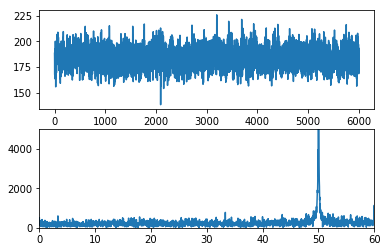

In [74]:
fr1 = np.fft.fftfreq(6000, d = 1/200)
tf1 = np.fft.fftshift(abs(np.fft.fft(X_mneRaw.get_data()[0,72000:78000])))

plt.subplot(211)
plt.plot(X_mneRaw.get_data()[0,72000:78000])

plt.subplot(212)
plt.xlim((0,60))
plt.ylim((0,5000))
plt.plot(fr1, tf1)

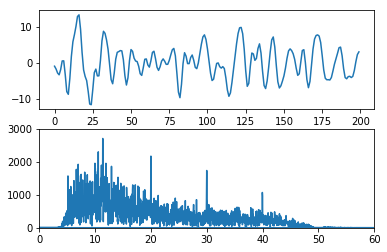

In [83]:
fr2 = np.fft.fftfreq(6000, d = 1/200)
tf2 = abs(np.fft.fft(X_mneProc.get_data()[0,72000:78000]))

plt.subplot(211)
plt.plot(X_mneProc.get_data()[0,72000:72200])

plt.subplot(212)
plt.xlim((0,60))
plt.ylim((0,3000))
plt.plot(fr2, tf2)

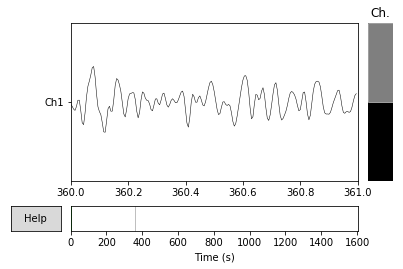

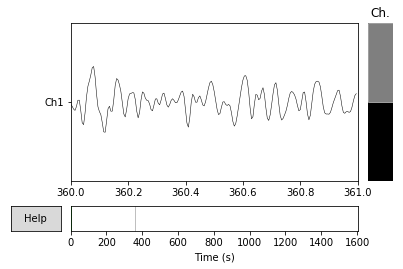

In [92]:
X_mneProc.plot(duration = 1.0, start = 360.0, n_channels = 1, scalings = dict(eeg=20))